In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import sys
Path = '/remote/tychodata/ftairli/work/Projects/FD_Reconstruction/Code/'
if Path not in sys.path:
    sys.path.append(Path)
import ManageData as MD

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

In [2]:
# Change degault font size
plt.rcParams.update({'font.size': 20})

In [3]:
Name = 'Model_1_3'
Model = torch.load(f'{Name}.pt')
Tracker = torch.load(f'{Name}_Tracker.pt')

In [4]:
# dir(Model)
Model.PhiDense3

Linear(in_features=8, out_features=1, bias=True)

In [5]:
print(f'Final Loss           : {Tracker.EpochLoss[-1]}')
print(f'Final Validation Loss: {Tracker.EpochValLoss[-1]}')

Final Loss           : 0.013302259520663079
Final Validation Loss: 0.021211934812192128


In [6]:
# Find The best loss in validation and apply the model weights

# BestLoss = np.argmin(Tracker.EpochValLoss)
# print(BestLoss)
# BestLoss = 25
# print(len(Tracker.EpochValLoss))
# Model.load_state_dict(Tracker.ModelStates[BestLoss])

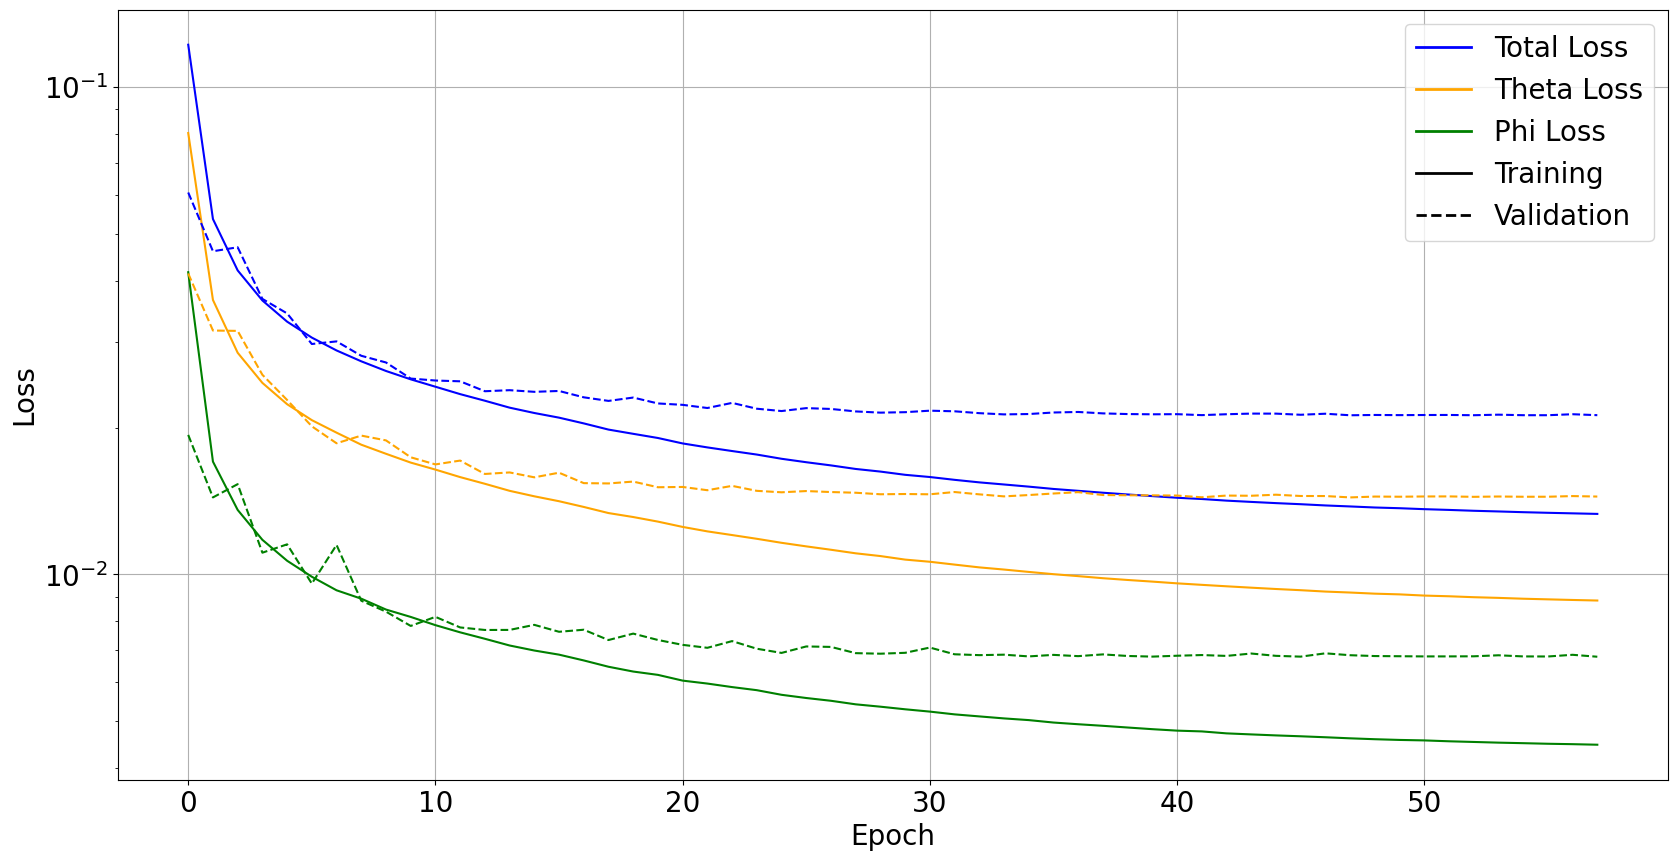

In [7]:
# plt.figure(figsize=(10, 10))
# plt.plot(Tracker.EpochLoss)
# plt.plot(Tracker.EpochValLoss)
# plt.yscale('log')

Total_loss = Tracker.EpochLoss
Theta_loss = Tracker.EpochLossTheta
Phi_loss   = Tracker.EpochLossPhi

Total_loss_val = Tracker.EpochValLoss
Theta_loss_val = Tracker.EpochValLossTheta
Phi_loss_val   = Tracker.EpochValLossPhi

Nepochs = len(Total_loss)
plt.figure(figsize=(20, 10))

# Define colors
colors = ['blue', 'orange', 'green', 'red','cyan']

# Plot training loss
plt.plot(Total_loss, color=colors[0], label='Total Loss - Training')
plt.plot(Theta_loss, color=colors[1], label='Theta Loss - Training')
plt.plot(Phi_loss  , color=colors[2], label='Phi   Loss - Training')

# # Plot validation loss
plt.plot(Total_loss_val, color=colors[0], linestyle='dashed', label='Total Loss - Validation')
plt.plot(Theta_loss_val, color=colors[1], linestyle='dashed', label='Theta Loss - Validation')
plt.plot(Phi_loss_val  , color=colors[2], linestyle='dashed', label='Phi   Loss - Validation')

# Set up custom legend

custom_lines = [Line2D([0], [0], color=colors[0], lw=2),
                Line2D([0], [0], color=colors[1], lw=2),
                Line2D([0], [0], color=colors[2], lw=2),
                Line2D([0], [0], color='black'  , lw=2),
                Line2D([0], [0], color='black', linestyle='dashed', lw=2)]

plt.legend(custom_lines, ['Total Loss', 'Theta Loss', 'Phi Loss', 'Training', 'Validation'])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid()
plt.savefig(f'{Name}_Loss.png', dpi=300)


In [8]:
datapath = '/remote/tychodata/ftairli/work/Projects/FD_Reconstruction/Data/NormData/'
GenGeometry = torch.load(f'{datapath}GenGeometry_test.pt')
RecGeometry = torch.load(f'{datapath}RecGeometry_test.pt')
Main        = torch.load(f'{datapath}Main_test.pt')
Meta        = torch.load(f'{datapath}Meta_test.pt')


Main[torch.isinf(Main)] = 0.0

TruthSDP = GenGeometry[:,[3,4]]
RecSDP   = RecGeometry[:,[3,4]]
PredSDP = torch.zeros_like(TruthSDP)

Main[:,0,:,:] = MD.PixTime_to_net(Main[:,0,:,:])
Main[:,1,:,:] = MD.PixSig_to_net(Main[:,1,:,:])

Main = Main.to('cuda')
PredSDP = PredSDP.to('cuda')

Model.eval()
with torch.no_grad():
    for i in range(len(Main)):
        print(i,end='\r')
        PredSDP[i,:],normStateOut = Model(Main[i].unsqueeze(0),normStateOut = 'Net',normStateIn = 'Net')
        
PredSDP = PredSDP.cpu()

# Normalise SDP
# Phi
TruthSDP[:,0] = MD.Phi_to_mirror(TruthSDP[:,0],Meta[:,9])
RecSDP[:,0]   = MD.Phi_to_mirror(RecSDP[:,0],Meta[:,9])
# Pred Phi already in Mirror
TruthSDP[:,0] = MD.Phi_to_net(TruthSDP[:,0])
RecSDP[:,0]   = MD.Phi_to_net(RecSDP[:,0])
# Phi SDP already in Net

# Theta
TruthSDP[:,1] = MD.Theta_to_net(TruthSDP[:,1])
RecSDP[:,1]   = MD.Theta_to_net(RecSDP[:,1])
# Pred Theta already in Net


# UnNet Everything

# Phi
TruthSDP[:,0] = MD.Phi_to_val(TruthSDP[:,0])
RecSDP[:,0]   = MD.Phi_to_val(RecSDP[:,0])
PredSDP[:,0]  = MD.Phi_to_val(PredSDP[:,0])

# Theta
TruthSDP[:,1] = MD.Theta_to_val(TruthSDP[:,1])
RecSDP[:,1]   = MD.Theta_to_val(RecSDP[:,1])
PredSDP[:,1]  = MD.Theta_to_val(PredSDP[:,1])


# Delete Infs and nans
mask = torch.isnan(TruthSDP[:,0]) | torch.isnan(TruthSDP[:,1]) | torch.isnan(RecSDP[:,0]) | torch.isnan(RecSDP[:,1]) | torch.isnan(PredSDP[:,0]) | torch.isnan(PredSDP[:,1])
TruthSDP = TruthSDP[~mask]
RecSDP   = RecSDP[~mask]
PredSDP  = PredSDP[~mask]
Main     = Main[~mask]


In [19]:
def MeanAbsoluteError(pred,truth):
    return np.mean(np.abs(pred-truth)) if type(pred) == np.ndarray else torch.mean(torch.abs(pred-truth))
def AbsoulteDeviation(pred,truth):
    return np.std(np.abs(pred-truth)) if type(pred) == np.ndarray else torch.std(torch.abs(pred-truth))
def Deviation(pred,truth):
    return np.std((pred-truth)) if type(pred) == np.ndarray else torch.std((pred-truth))
def Bias(pred,truth):
    return np.mean(pred-truth) if type(pred) == np.ndarray else torch.mean(pred-truth)
def Percentile68(pred,truth):
    return np.percentile(np.abs(pred-truth),68) if type(pred) == np.ndarray else torch.quantile(torch.abs(pred-truth),0.68)
# print(torch.isfinite(PredSDP).sum().item())
# print(PredSDP.numel())

print('Error in Phi      :',MeanAbsoluteError(PredSDP[:,0],TruthSDP[:,0])/np.pi*180)
print('Error in Theta    :',MeanAbsoluteError(PredSDP[:,1],TruthSDP[:,1])/np.pi*180)
print('Error in RecPhi   :',MeanAbsoluteError(RecSDP[:,0],TruthSDP[:,0])/np.pi*180)
print('Error in RecTheta :',MeanAbsoluteError(RecSDP[:,1],TruthSDP[:,1])/np.pi*180)

print()
print('Bias in Phi      :',Bias(PredSDP[:,0],TruthSDP[:,0])/np.pi*180)
print('Bias in Theta    :',Bias(PredSDP[:,1],TruthSDP[:,1])/np.pi*180)
print('Bias in RecPhi   :',Bias(RecSDP[:,0],TruthSDP[:,0])/np.pi*180)
print('Bias in RecTheta :',Bias(RecSDP[:,1],TruthSDP[:,1])/np.pi*180)

print()
print('Deviation in Phi      :',AbsoulteDeviation(PredSDP[:,0],TruthSDP[:,0])/np.pi*180)
print('Deviation in Theta    :',AbsoulteDeviation(PredSDP[:,1],TruthSDP[:,1])/np.pi*180)
print('Deviation in RecPhi   :',AbsoulteDeviation(RecSDP[:,0],TruthSDP[:,0])/np.pi*180)
print('Deviation in RecTheta :',AbsoulteDeviation(RecSDP[:,1],TruthSDP[:,1])/np.pi*180)

print()
print('Deviation in Phi      :',Deviation(PredSDP[:,0],TruthSDP[:,0])/np.pi*180)
print('Deviation in Theta    :',Deviation(PredSDP[:,1],TruthSDP[:,1])/np.pi*180)
print('Deviation in RecPhi   :',Deviation(RecSDP[:,0],TruthSDP[:,0])/np.pi*180)
print('Deviation in RecTheta :',Deviation(RecSDP[:,1],TruthSDP[:,1])/np.pi*180)

print()
print('68% in Phi            :',Percentile68(PredSDP[:,0],TruthSDP[:,0])/np.pi*180)
print('68% in Theta          :',Percentile68(PredSDP[:,1],TruthSDP[:,1])/np.pi*180)
print('68% in RecPhi         :',Percentile68(RecSDP[:,0],TruthSDP[:,0])/np.pi*180)
print('68% in RecTheta       :',Percentile68(RecSDP[:,1],TruthSDP[:,1])/np.pi*180)

Error in Phi      : tensor(0.4294)
Error in Theta    : tensor(0.9993)
Error in RecPhi   : tensor(0.3351)
Error in RecTheta : tensor(0.8834)

Bias in Phi      : tensor(-0.0122)
Bias in Theta    : tensor(-0.0011)
Bias in RecPhi   : tensor(-0.0319)
Bias in RecTheta : tensor(-0.1330)

Deviation in Phi      : tensor(1.4671)
Deviation in Theta    : tensor(1.8919)
Deviation in RecPhi   : tensor(2.1537)
Deviation in RecTheta : tensor(4.2966)

Deviation in Phi      : tensor(1.5287)
Deviation in Theta    : tensor(2.1396)
Deviation in RecPhi   : tensor(2.1794)
Deviation in RecTheta : tensor(4.3845)

68% in Phi            : tensor(0.3768)
68% in Theta          : tensor(0.8979)
68% in RecPhi         : tensor(0.2055)
68% in RecTheta       : tensor(0.5946)


In [30]:
# Values for the Model_1_3:
# Error in Phi      : tensor(0.4294)
# Error in Theta    : tensor(0.9993)
# Error in RecPhi   : tensor(0.3351)
# Error in RecTheta : tensor(0.8834)

# Bias in Phi      : tensor(-0.0122)
# Bias in Theta    : tensor(-0.0011)
# Bias in RecPhi   : tensor(-0.0319)
# Bias in RecTheta : tensor(-0.1330)

# Deviation in Phi      : tensor(1.4671)
# Deviation in Theta    : tensor(1.8919)
# Deviation in RecPhi   : tensor(2.1537)
# Deviation in RecTheta : tensor(4.2966)

# Deviation in Phi      : tensor(1.5287)
# Deviation in Theta    : tensor(2.1396)
# Deviation in RecPhi   : tensor(2.1794)
# Deviation in RecTheta : tensor(4.3845)

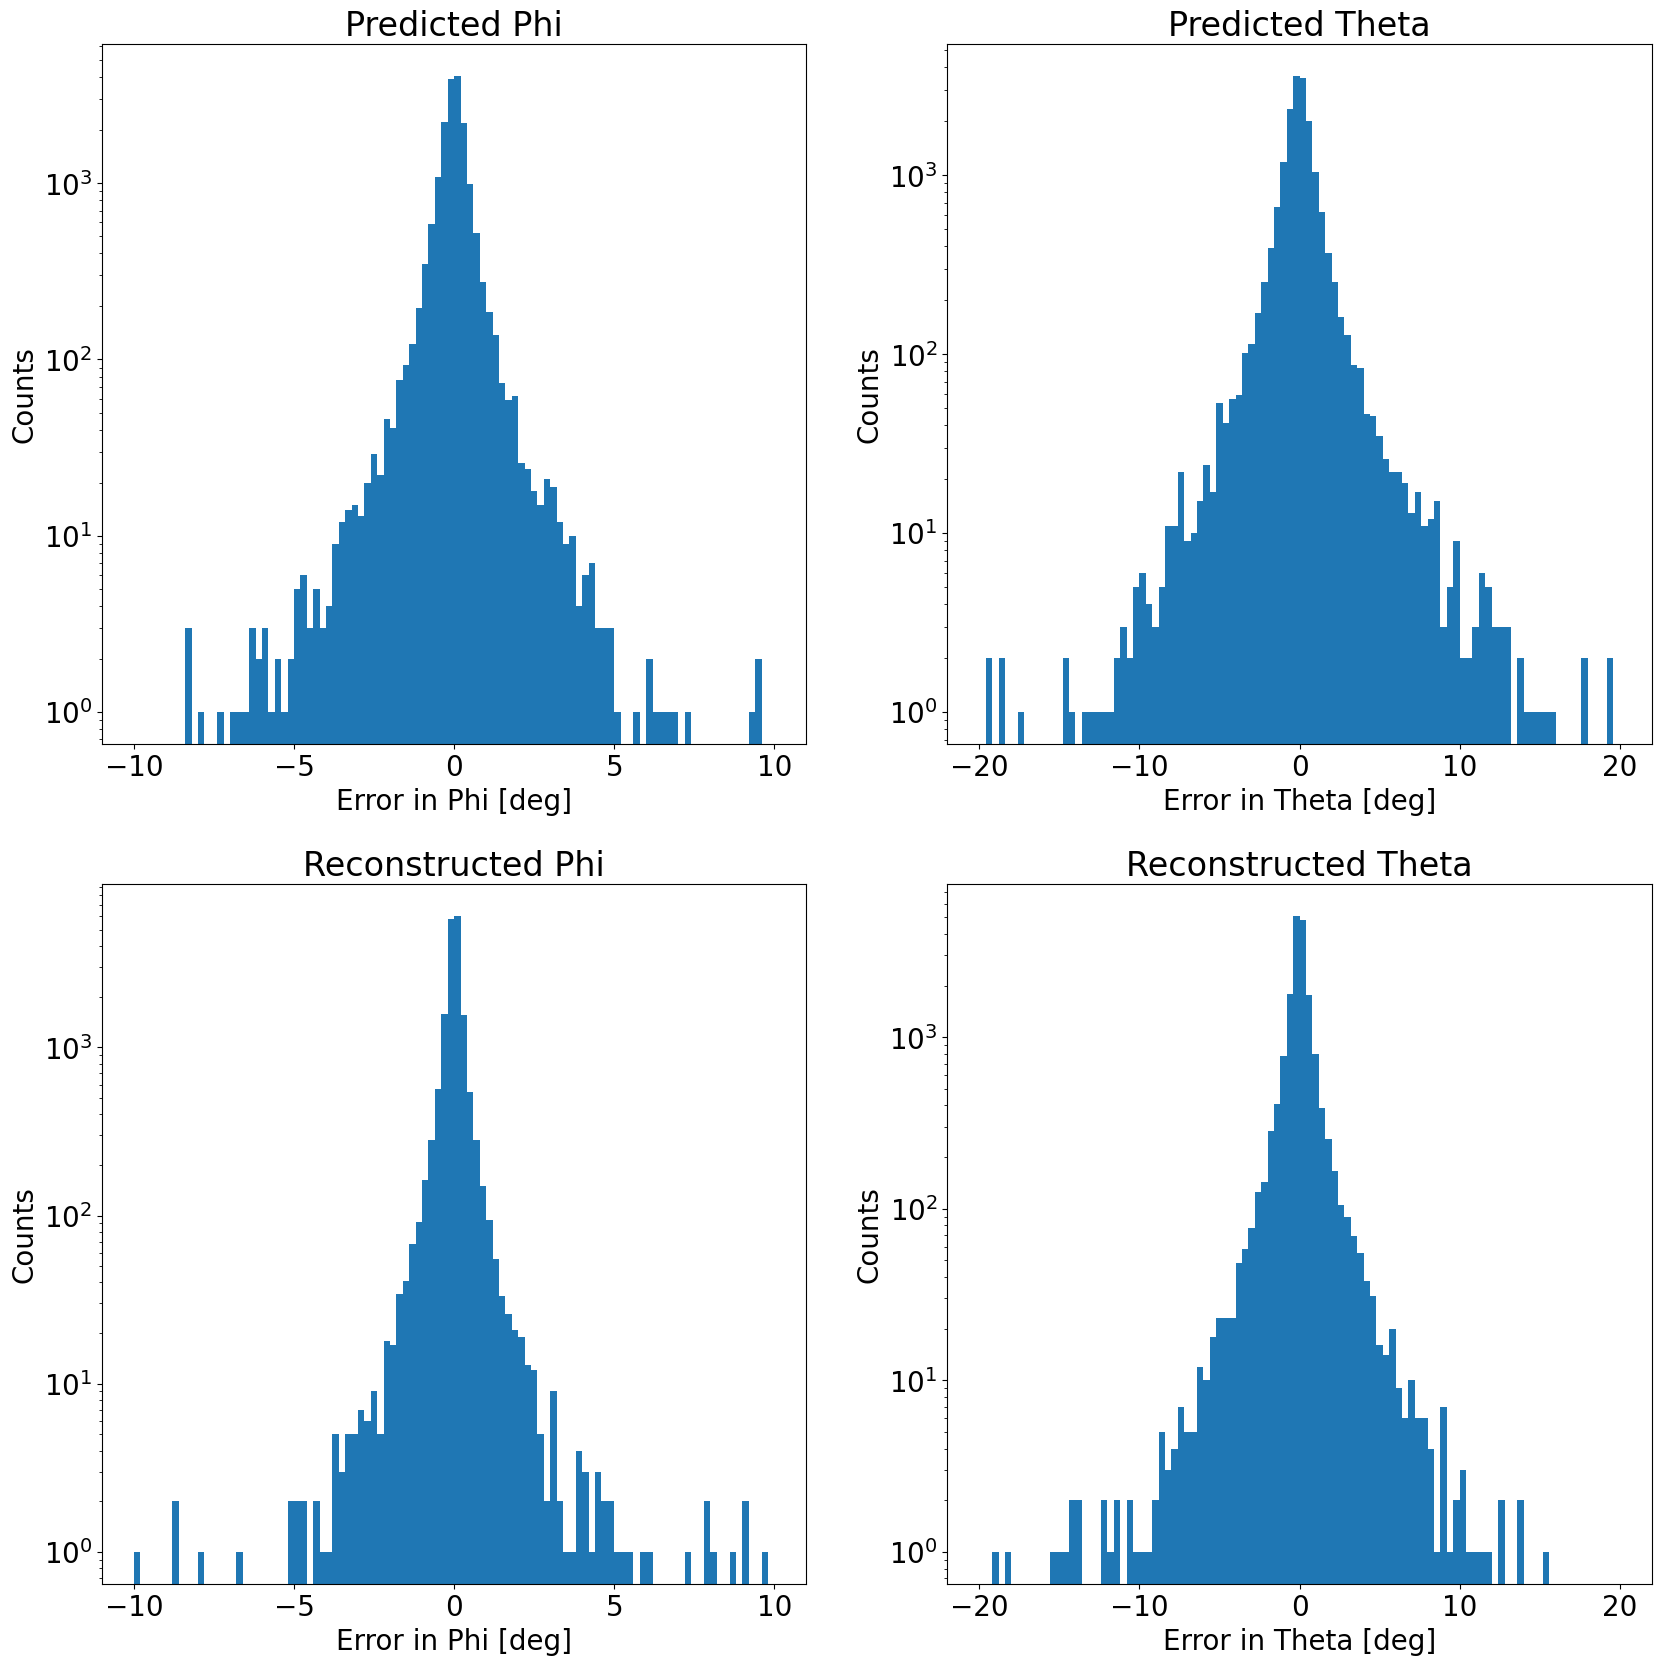

In [31]:
X    = (PredSDP[:,0]-TruthSDP[:,0])/np.pi*180
Y    = (PredSDP[:,1]-TruthSDP[:,1])/np.pi*180
XRec = (RecSDP[:,0]-TruthSDP[:,0])/np.pi*180
YRec = (RecSDP[:,1]-TruthSDP[:,1])/np.pi*180

fig,ax = plt.subplots(2,2,figsize=(20,20))
ax[0,0].hist(X,bins=100,range = (-10,10))
ax[0,0].set_xlabel('Error in Phi [deg]')
ax[0,0].set_ylabel('Counts')
ax[0,0].set_title('Predicted Phi')
ax[0,0].set_yscale('log')


ax[0,1].hist(Y,bins=100,range = (-20,20))
ax[0,1].set_xlabel('Error in Theta [deg]')
ax[0,1].set_ylabel('Counts')
ax[0,1].set_title('Predicted Theta')
ax[0,1].set_yscale('log')


ax[1,0].hist(XRec,bins=100,range = (-10,10))
ax[1,0].set_xlabel('Error in Phi [deg]')
ax[1,0].set_ylabel('Counts')
ax[1,0].set_title('Reconstructed Phi')
ax[1,0].set_yscale('log')


ax[1,1].hist(YRec,bins=100,range = (-20,20))
ax[1,1].set_xlabel('Error in Theta [deg]')
ax[1,1].set_ylabel('Counts')
ax[1,1].set_title('Reconstructed Theta')
ax[1,1].set_yscale('log')


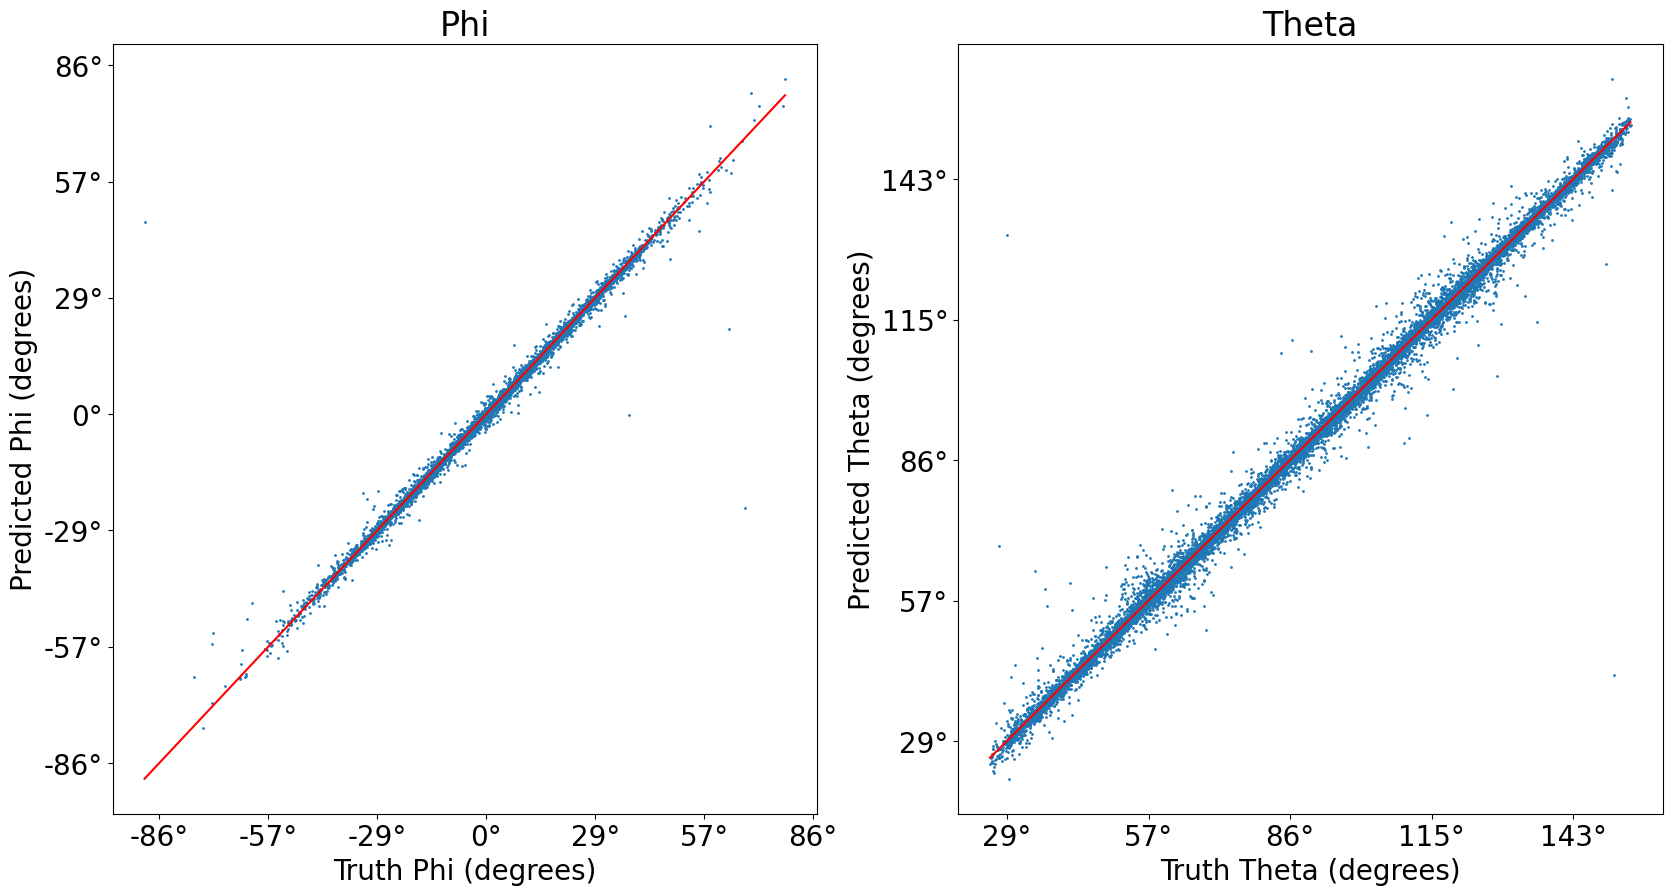

In [20]:
# Easy Scatter Plots
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Scatter plot for the first subplot
ax[0].scatter(TruthSDP[:, 0], PredSDP[:, 0], s=1)
ax[0].plot([min(TruthSDP[:, 0]), max(TruthSDP[:, 0])], [min(TruthSDP[:, 0]), max(TruthSDP[:, 0])], 'r')
ax[0].set_xlabel('Truth Phi (degrees)')
ax[0].set_ylabel('Predicted Phi (degrees)')
ax[0].set_title('Phi')

# Set x and y ticks for the first subplot
xticks = ax[0].get_xticks()
ax[0].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
yticks = ax[0].get_yticks()
ax[0].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])

# Scatter plot for the second subplot
ax[1].scatter(TruthSDP[:, 1], PredSDP[:, 1], s=1)
ax[1].plot([min(TruthSDP[:, 1]), max(TruthSDP[:, 1])], [min(TruthSDP[:, 1]), max(TruthSDP[:, 1])], 'r')
ax[1].set_xlabel('Truth Theta (degrees)')
ax[1].set_ylabel('Predicted Theta (degrees)')
ax[1].set_title('Theta')

# Set x and y ticks for the second subplot
xticks = ax[1].get_xticks()
ax[1].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
yticks = ax[1].get_yticks()
ax[1].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])

plt.show()


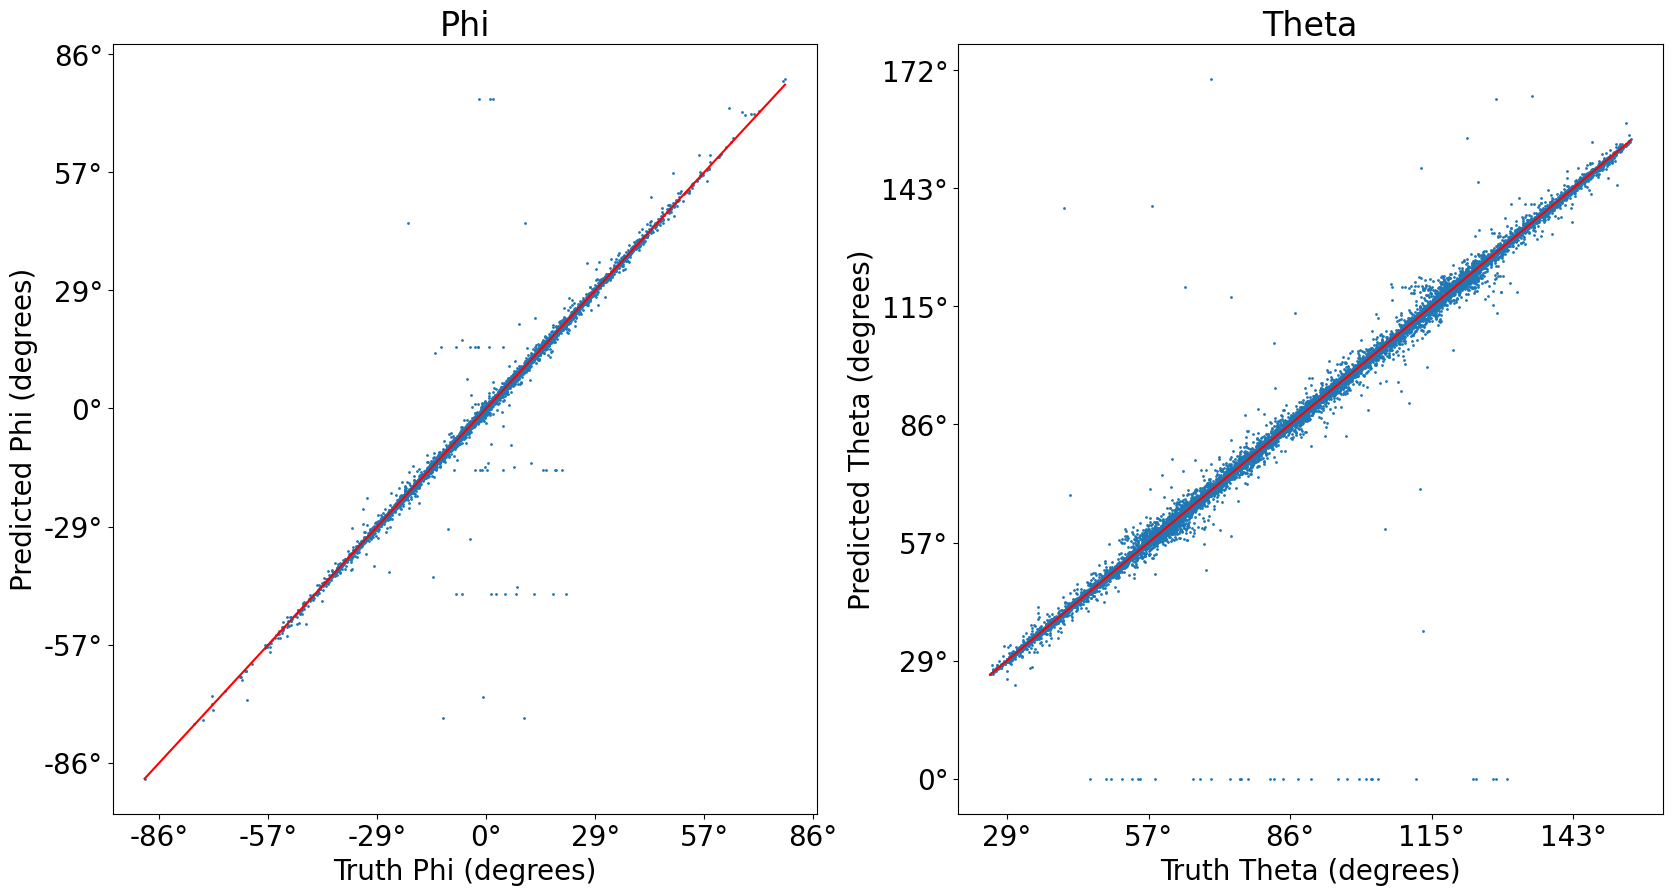

In [21]:
# Easy Scatter Plots
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Scatter plot for the first subplot
ax[0].scatter(TruthSDP[:, 0], RecSDP[:, 0], s=1)
ax[0].plot([min(TruthSDP[:, 0]), max(TruthSDP[:, 0])], [min(TruthSDP[:, 0]), max(TruthSDP[:, 0])], 'r')
ax[0].set_xlabel('Truth Phi (degrees)')
ax[0].set_ylabel('Predicted Phi (degrees)')
ax[0].set_title('Phi')

# Set x and y ticks for the first subplot
xticks = ax[0].get_xticks()
ax[0].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
yticks = ax[0].get_yticks()
ax[0].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])

# Scatter plot for the second subplot
ax[1].scatter(TruthSDP[:, 1], RecSDP[:, 1], s=1)
ax[1].plot([min(TruthSDP[:, 1]), max(TruthSDP[:, 1])], [min(TruthSDP[:, 1]), max(TruthSDP[:, 1])], 'r')
ax[1].set_xlabel('Truth Theta (degrees)')
ax[1].set_ylabel('Predicted Theta (degrees)')
ax[1].set_title('Theta')

# Set x and y ticks for the second subplot
xticks = ax[1].get_xticks()
ax[1].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
yticks = ax[1].get_yticks()
ax[1].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])

plt.show()


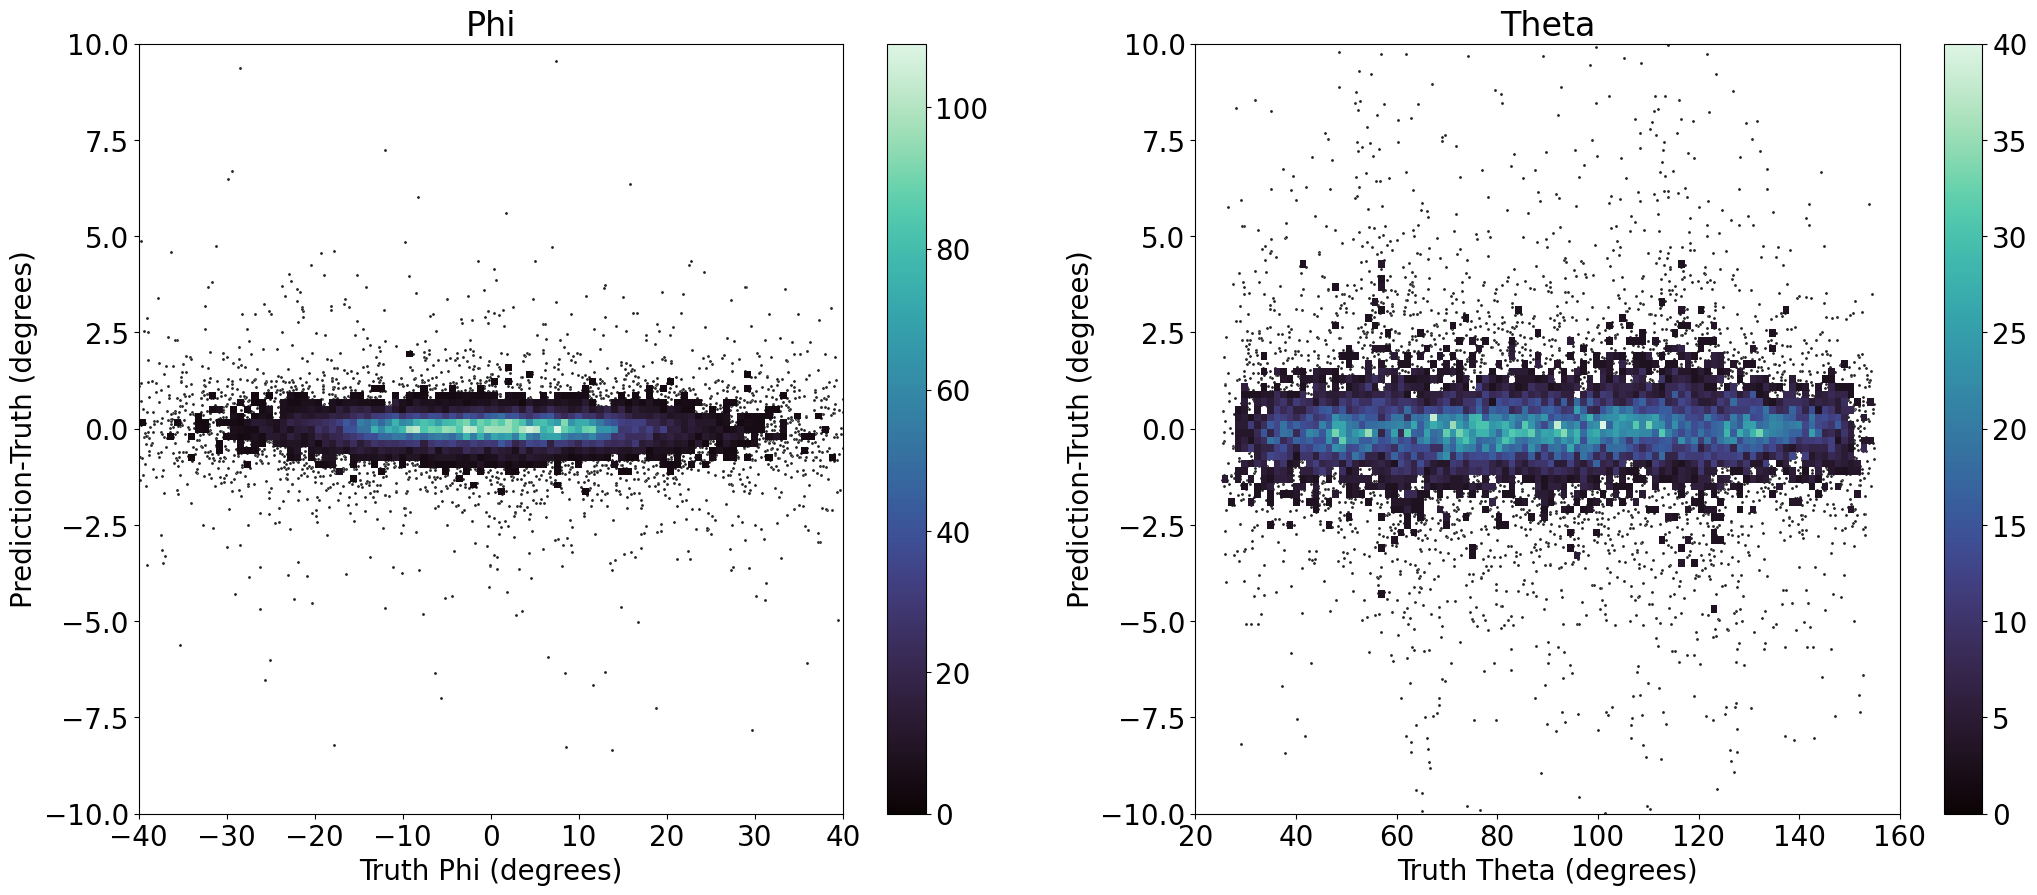

In [34]:
# Seaborn Difference plots

fig, ax = plt.subplots(1, 2, figsize=(25, 10))

# Scatter plot for the first subplot
X = TruthSDP[:, 0]/np.pi*180
Y = PredSDP[:, 0]/np.pi*180 - TruthSDP[:, 0]/np.pi*180
cut = (np.abs(Y) < 10) & (np.abs(X) < 40)
X = X[cut]
Y = Y[cut]

sns.scatterplot(x=X, y=Y, ax=ax[0], s=5,color='.15')
sns.histplot(x=X, y=Y, ax=ax[0], bins=100, pthresh=.1,cmap = 'mako',cbar = True)
ax[0].set_xlabel('Truth Phi (degrees)')
ax[0].set_ylabel('Prediction-Truth (degrees)')
ax[0].set_title('Phi')
ax[0].set_xlim(-40,40)
ax[0].set_ylim(-10,10)

X = TruthSDP[:, 1]/np.pi*180
Y = PredSDP[:, 1]/np.pi*180 - TruthSDP[:, 1]/np.pi*180
cut = np.abs(Y) < 10
X = X[cut]
Y = Y[cut]

sns.scatterplot(x=X, y=Y, ax=ax[1], s=5,color='.15')
sns.histplot(x=X, y=Y, ax=ax[1], bins=100, pthresh=.1,cmap = 'mako',cbar = True)
ax[1].set_xlabel('Truth Theta (degrees)')
ax[1].set_ylabel('Prediction-Truth (degrees)')
ax[1].set_title('Theta')
ax[1].set_xlim(20,160)
ax[1].set_ylim(-10,10)


plt.show()


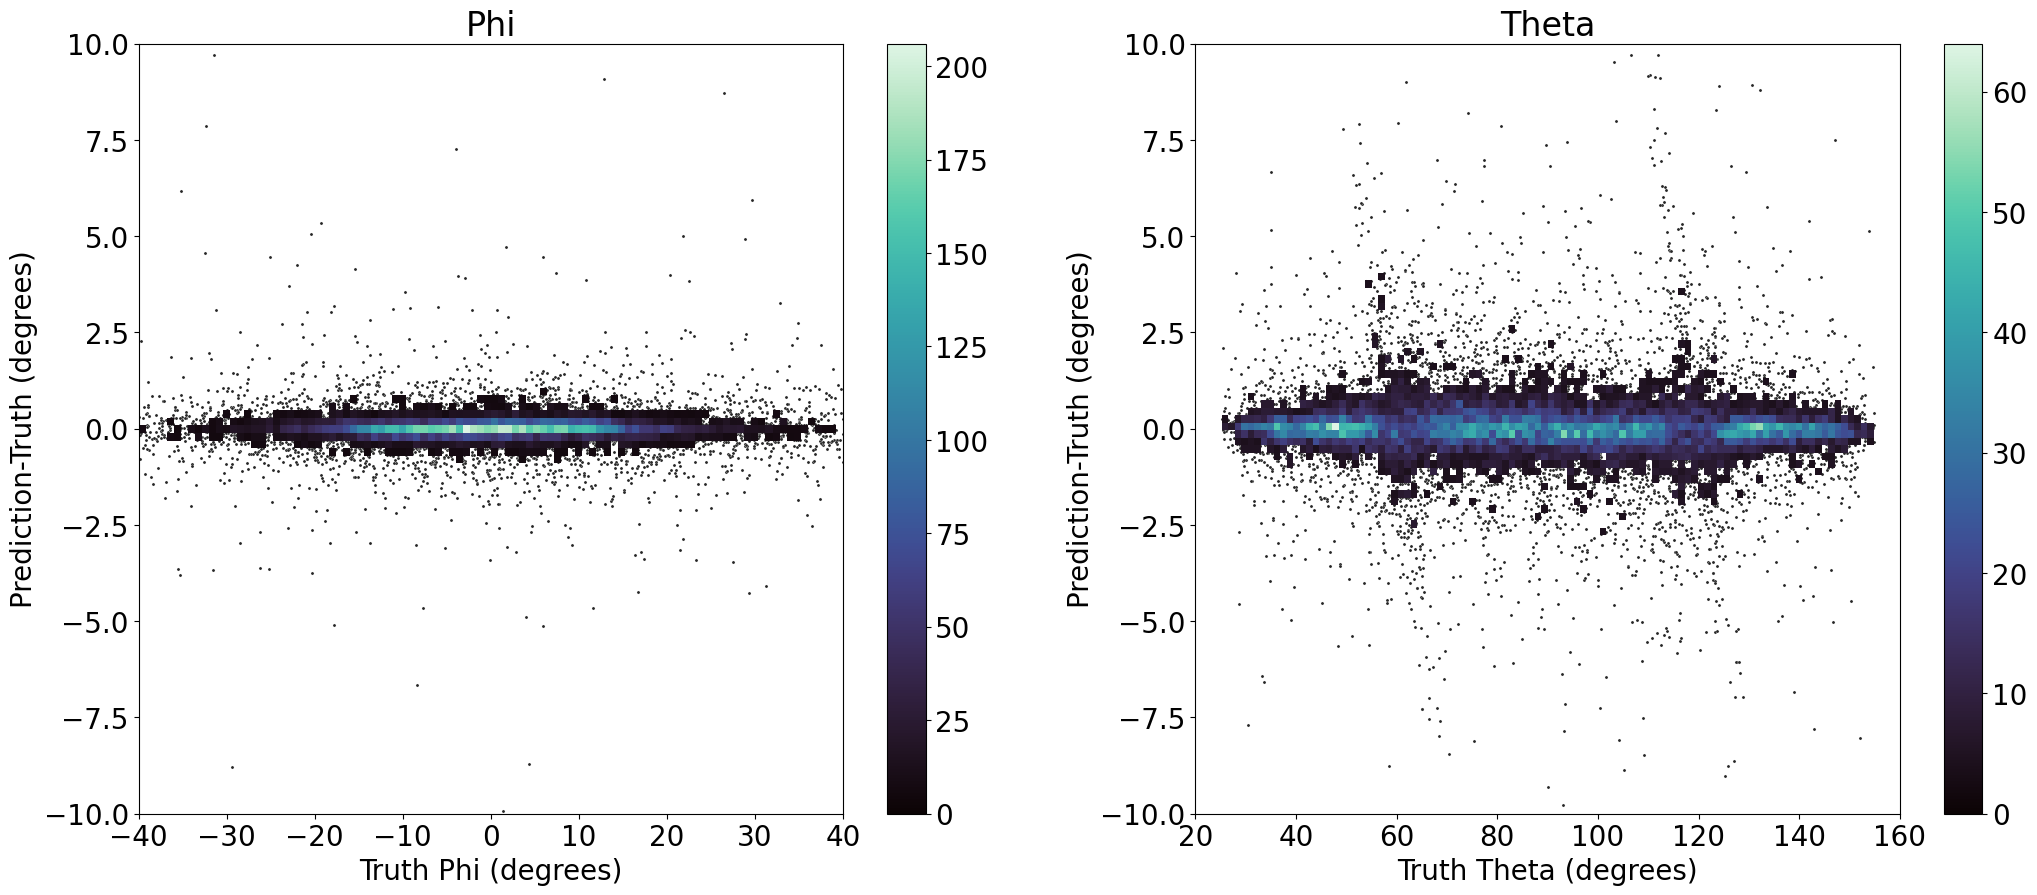

In [35]:
# Seaborn Difference plots

fig, ax = plt.subplots(1, 2, figsize=(25, 10))

# Scatter plot for the first subplot
X = TruthSDP[:, 0]/np.pi*180
Y = RecSDP[:, 0]/np.pi*180 - TruthSDP[:, 0]/np.pi*180
cut = (np.abs(Y) < 10) & (np.abs(X) < 40)
X = X[cut]
Y = Y[cut]

sns.scatterplot(x=X, y=Y, ax=ax[0], s=5,color='.15')
sns.histplot(x=X, y=Y, ax=ax[0], bins=100, pthresh=.1,cmap = 'mako',cbar = True)
ax[0].set_xlabel('Truth Phi (degrees)')
ax[0].set_ylabel('Prediction-Truth (degrees)')
ax[0].set_title('Phi')
ax[0].set_xlim(-40,40)
ax[0].set_ylim(-10,10)

X = TruthSDP[:, 1]/np.pi*180
Y = RecSDP[:, 1]/np.pi*180 - TruthSDP[:, 1]/np.pi*180
cut = np.abs(Y) < 10
X = X[cut]
Y = Y[cut]

sns.scatterplot(x=X, y=Y, ax=ax[1], s=5,color='.15')
sns.histplot(x=X, y=Y, ax=ax[1], bins=100, pthresh=.1,cmap = 'mako',cbar=True)
ax[1].set_xlabel('Truth Theta (degrees)')
ax[1].set_ylabel('Prediction-Truth (degrees)')
ax[1].set_title('Theta')
ax[1].set_xlim(20,160)
ax[1].set_ylim(-10,10)


plt.show()


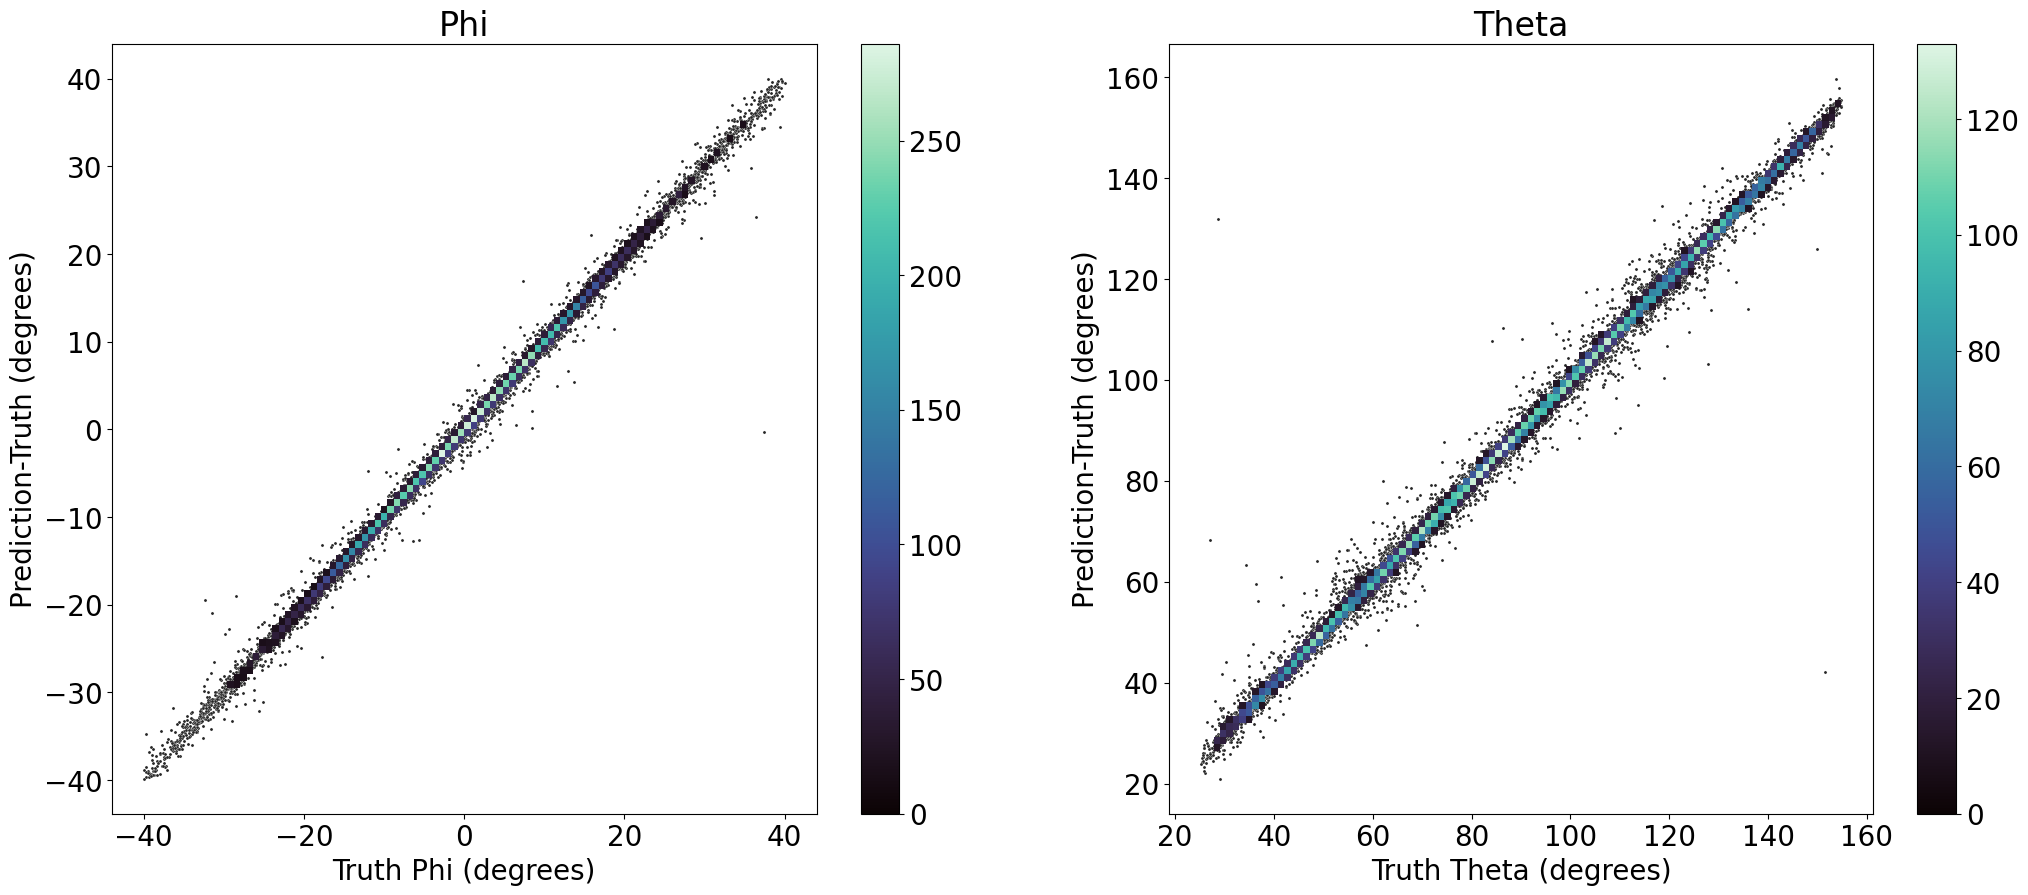

In [36]:
# Seaborn plots

fig, ax = plt.subplots(1, 2, figsize=(25, 10))

# Scatter plot for the first subplot
X = TruthSDP[:, 0]/np.pi*180
Y = PredSDP[:, 0]/np.pi*180 #- TruthSDP[:, 0]/np.pi*180
cut = (np.abs(Y) < 40) & (np.abs(X) < 40)
X = X[cut]
Y = Y[cut]

sns.scatterplot(x=X, y=Y, ax=ax[0], s=5,color='.15')
sns.histplot(x=X, y=Y, ax=ax[0], bins=100, pthresh=.1,cmap = 'mako',cbar=True)
ax[0].set_xlabel('Truth Phi (degrees)')
ax[0].set_ylabel('Prediction-Truth (degrees)')
ax[0].set_title('Phi')
# ax[0].set_xlim(-40,40)
# ax[0].set_ylim(-10,10)

X = TruthSDP[:, 1]/np.pi*180
Y = PredSDP[:, 1]/np.pi*180 #- TruthSDP[:, 1]/np.pi*180
cut = (np.abs(Y) > 20) &(np.abs(Y) < 160)
X = X[cut]
Y = Y[cut]

sns.scatterplot(x=X, y=Y, ax=ax[1], s=5,color='.15')
sns.histplot(x=X, y=Y, ax=ax[1], bins=100, pthresh=.1,cmap = 'mako',cbar=True)
ax[1].set_xlabel('Truth Theta (degrees)')
ax[1].set_ylabel('Prediction-Truth (degrees)')
ax[1].set_title('Theta')
# ax[1].set_xlim(20,160)
# ax[1].set_ylim(-10,10)


plt.show()


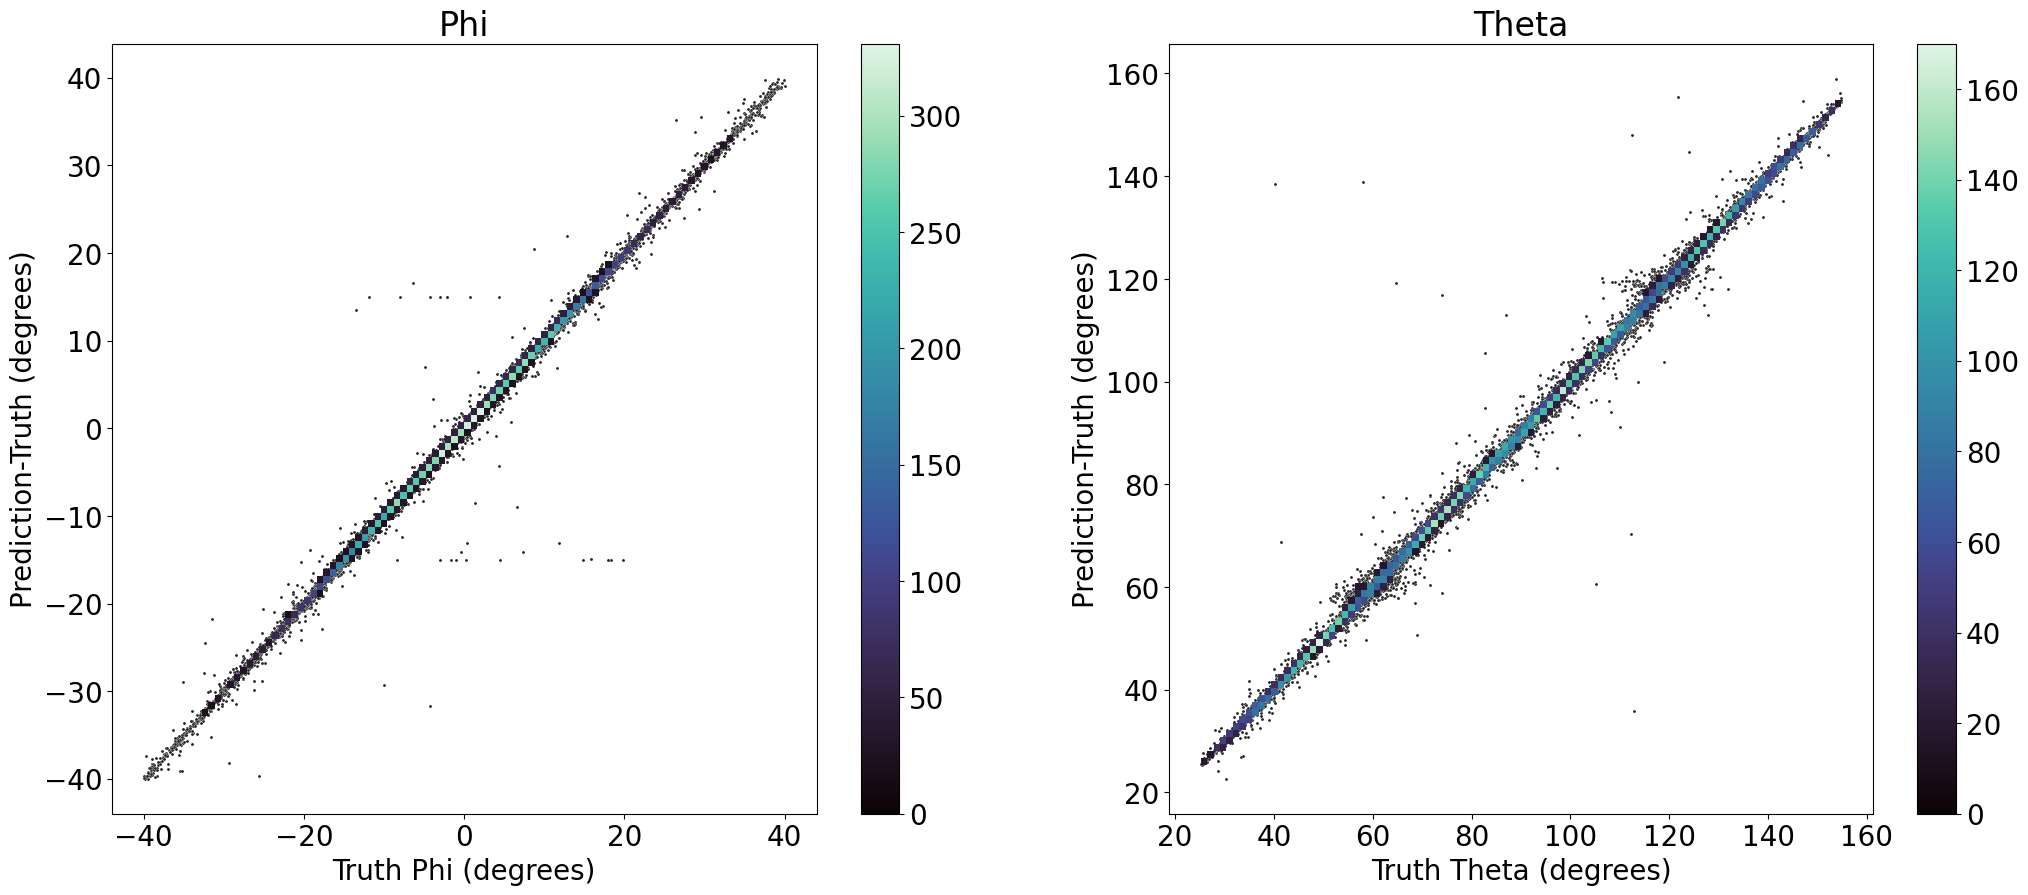

In [37]:
# Seaborn plots

fig, ax = plt.subplots(1, 2, figsize=(25, 10))

# Scatter plot for the first subplot
X = TruthSDP[:, 0]/np.pi*180
Y = RecSDP[:, 0]/np.pi*180 #- TruthSDP[:, 0]/np.pi*180
cut = (np.abs(Y) < 40) & (np.abs(X) < 40)
X = X[cut]
Y = Y[cut]

sns.scatterplot(x=X, y=Y, ax=ax[0], s=5,color='.15')
sns.histplot(x=X, y=Y, ax=ax[0], bins=100, pthresh=.1,cmap = 'mako',cbar=True)
ax[0].set_xlabel('Truth Phi (degrees)')
ax[0].set_ylabel('Prediction-Truth (degrees)')
ax[0].set_title('Phi')
# ax[0].set_xlim(-40,40)
# ax[0].set_ylim(-10,10)

X = TruthSDP[:, 1]/np.pi*180
Y = RecSDP[:, 1]/np.pi*180 #- TruthSDP[:, 1]/np.pi*180
cut = (np.abs(Y) > 20) &(np.abs(Y) < 160)
X = X[cut]
Y = Y[cut]

sns.scatterplot(x=X, y=Y, ax=ax[1], s=5,color='.15')
sns.histplot(x=X, y=Y, ax=ax[1], bins=100, pthresh=.1,cmap = 'mako',cbar=True)
ax[1].set_xlabel('Truth Theta (degrees)')
ax[1].set_ylabel('Prediction-Truth (degrees)')
ax[1].set_title('Theta')
# ax[1].set_xlim(20,160)
# ax[1].set_ylim(-10,10)


plt.show()


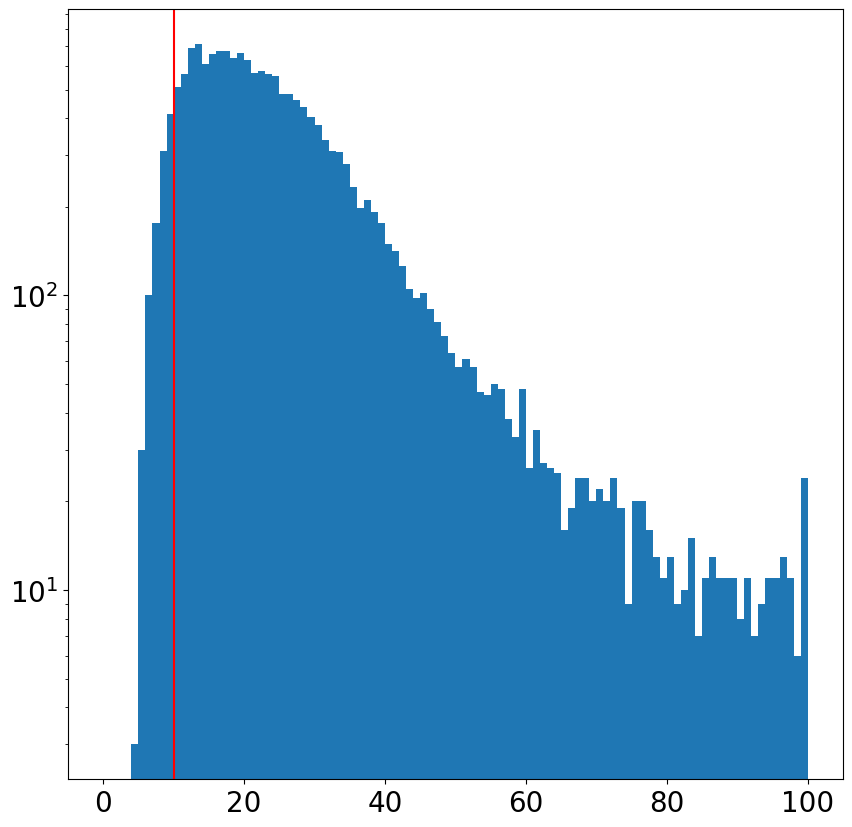

Number of Events with less than 10 pixels : 511
torch.Size([17721, 2, 22, 20])


In [38]:
Npix = (Main[:,1,:,:] !=0 ).float().sum(dim=[1,2]).cpu().numpy()
plt.figure(figsize=(10,10))
plt.hist(Npix,bins=range(101))
plt.yscale('log')
plt.axvline(10,color='red')
plt.show()

cut = Npix == 10
print(f'Number of Events with less than 10 pixels : {cut.sum()}')

print(Main.shape)

In [39]:
print(Npix.mean())

27.796005


In [40]:
LowPixTruthSDP = TruthSDP[cut]
LowPixRecSDP   = RecSDP[cut]
LowPixPredSDP  = PredSDP[cut]

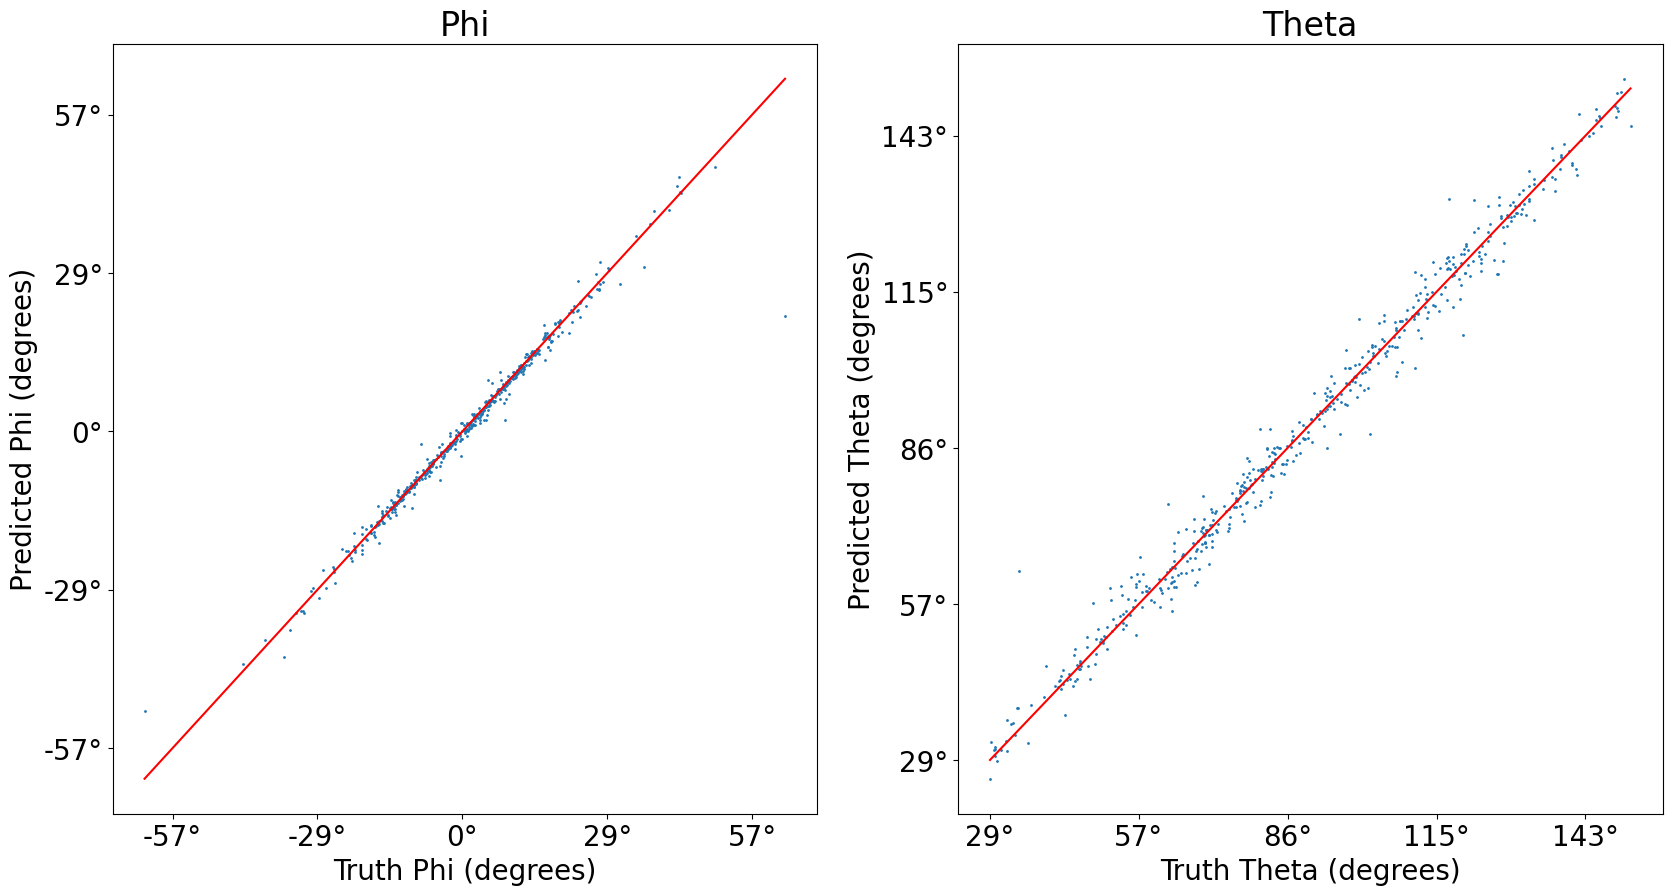

In [41]:

# Easy Scatter Plots with Low Pixel Events
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Scatter plot for the first subplot
ax[0].scatter(LowPixTruthSDP[:, 0], LowPixPredSDP[:, 0], s=1)
ax[0].plot([min(LowPixTruthSDP[:, 0]), max(LowPixTruthSDP[:, 0])], [min(LowPixTruthSDP[:, 0]), max(LowPixTruthSDP[:, 0])], 'r')
ax[0].set_xlabel('Truth Phi (degrees)')
ax[0].set_ylabel('Predicted Phi (degrees)')
ax[0].set_title('Phi')

# Set x and y ticks for the first subplot
xticks = ax[0].get_xticks()
ax[0].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
yticks = ax[0].get_yticks()
ax[0].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])

# Scatter plot for the second subplot
ax[1].scatter(LowPixTruthSDP[:, 1], LowPixPredSDP[:, 1], s=1)
ax[1].plot([min(LowPixTruthSDP[:, 1]), max(LowPixTruthSDP[:, 1])], [min(LowPixTruthSDP[:, 1]), max(LowPixTruthSDP[:, 1])], 'r')
ax[1].set_xlabel('Truth Theta (degrees)')
ax[1].set_ylabel('Predicted Theta (degrees)')
ax[1].set_title('Theta')

# Set x and y ticks for the second subplot
xticks = ax[1].get_xticks()
ax[1].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
yticks = ax[1].get_yticks()
ax[1].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])

plt.show()


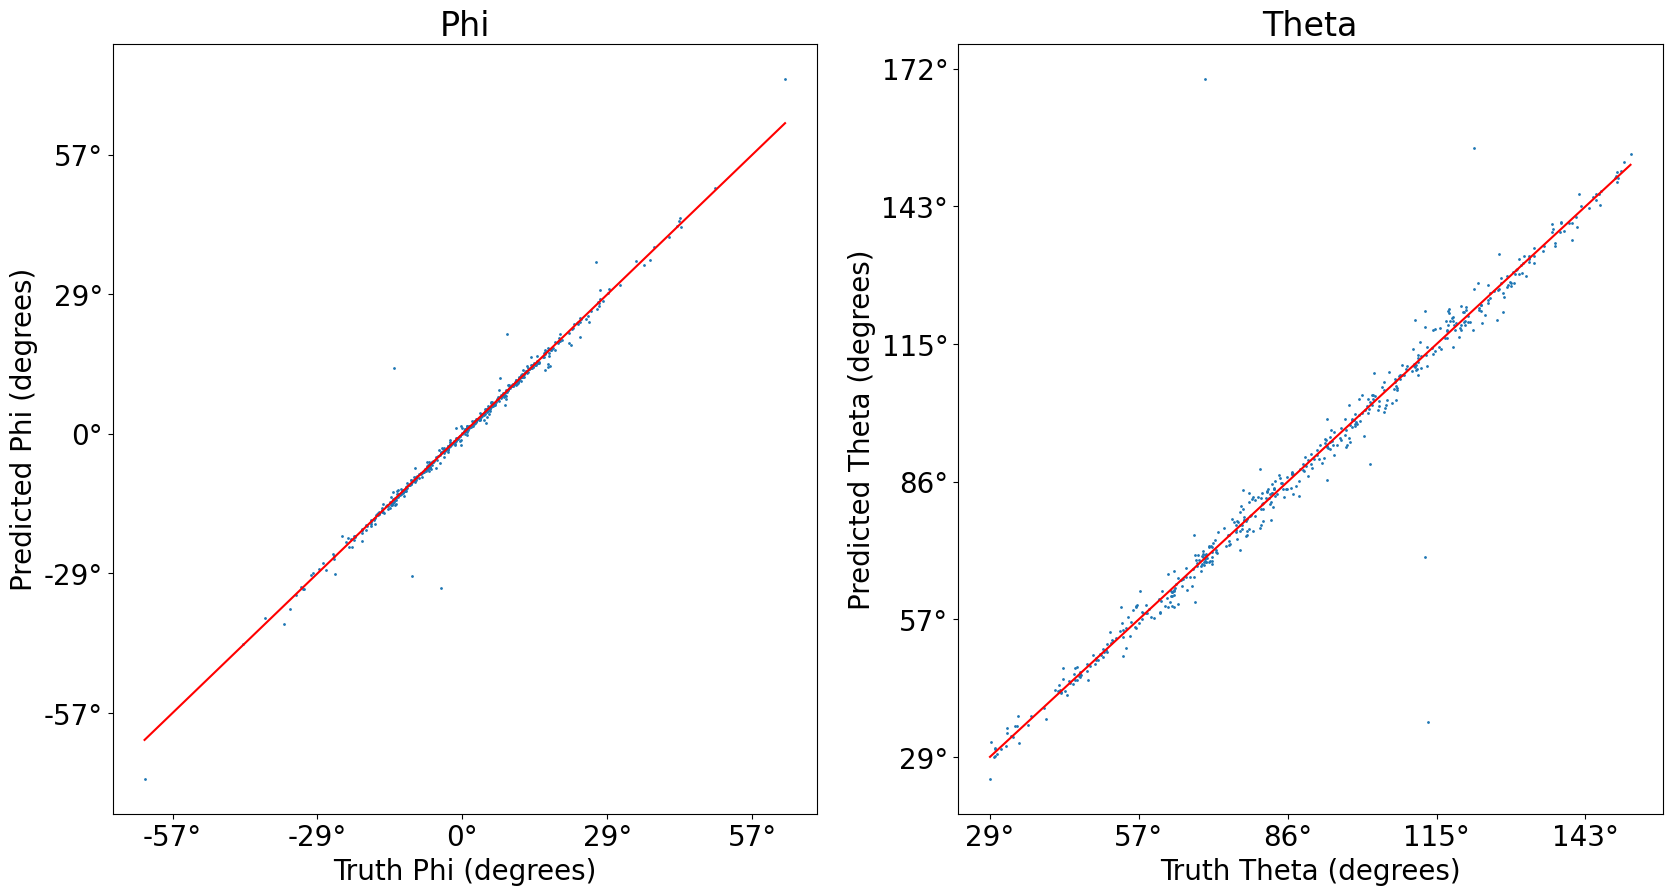

In [42]:
# Easy Scatter Plots with Low Pixel Events
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Scatter plot for the first subplot
ax[0].scatter(LowPixTruthSDP[:, 0], LowPixRecSDP[:, 0], s=1)
ax[0].plot([min(LowPixTruthSDP[:, 0]), max(LowPixTruthSDP[:, 0])], [min(LowPixTruthSDP[:, 0]), max(LowPixTruthSDP[:, 0])], 'r')
ax[0].set_xlabel('Truth Phi (degrees)')
ax[0].set_ylabel('Predicted Phi (degrees)')
ax[0].set_title('Phi')

# Set x and y ticks for the first subplot
xticks = ax[0].get_xticks()
ax[0].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
yticks = ax[0].get_yticks()
ax[0].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])

# Scatter plot for the second subplot
ax[1].scatter(LowPixTruthSDP[:, 1], LowPixRecSDP[:, 1], s=1)
ax[1].plot([min(LowPixTruthSDP[:, 1]), max(LowPixTruthSDP[:, 1])], [min(LowPixTruthSDP[:, 1]), max(LowPixTruthSDP[:, 1])], 'r')
ax[1].set_xlabel('Truth Theta (degrees)')
ax[1].set_ylabel('Predicted Theta (degrees)')
ax[1].set_title('Theta')

# Set x and y ticks for the second subplot
xticks = ax[1].get_xticks()
ax[1].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
yticks = ax[1].get_yticks()
ax[1].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])

plt.show()


In [43]:
# Values for Low Pixel Events
# print(torch.isfinite(LowPixPredSDP).sum().item())
# print(LowPixPredSDP.numel())

print('Error in Phi      :',MeanAbsoluteError(LowPixPredSDP[:,0],LowPixTruthSDP[:,0])/np.pi*180)
print('Error in Theta    :',MeanAbsoluteError(LowPixPredSDP[:,1],LowPixTruthSDP[:,1])/np.pi*180)
print('Error in RecPhi   :',MeanAbsoluteError(LowPixRecSDP[:,0],LowPixTruthSDP[:,0])/np.pi*180)
print('Error in RecTheta :',MeanAbsoluteError(LowPixRecSDP[:,1],LowPixTruthSDP[:,1])/np.pi*180)

print()
print('Bias in Phi      :',Bias(LowPixPredSDP[:,0],LowPixTruthSDP[:,0])/np.pi*180)
print('Bias in Theta    :',Bias(LowPixPredSDP[:,1],LowPixTruthSDP[:,1])/np.pi*180)
print('Bias in RecPhi   :',Bias(LowPixRecSDP[:,0],LowPixTruthSDP[:,0])/np.pi*180)
print('Bias in RecTheta :',Bias(LowPixRecSDP[:,1],LowPixTruthSDP[:,1])/np.pi*180)

print()
print('Deviation in Phi      :',AbsoulteDeviation(LowPixPredSDP[:,0],LowPixTruthSDP[:,0])/np.pi*180)
print('Deviation in Theta    :',AbsoulteDeviation(LowPixPredSDP[:,1],LowPixTruthSDP[:,1])/np.pi*180)
print('Deviation in RecPhi   :',AbsoulteDeviation(LowPixRecSDP[:,0],LowPixTruthSDP[:,0])/np.pi*180)
print('Deviation in RecTheta :',AbsoulteDeviation(LowPixRecSDP[:,1],LowPixTruthSDP[:,1])/np.pi*180)

print()
print('Deviation in Phi      :',Deviation(LowPixPredSDP[:,0],LowPixTruthSDP[:,0])/np.pi*180)
print('Deviation in Theta    :',Deviation(LowPixPredSDP[:,1],LowPixTruthSDP[:,1])/np.pi*180)
print('Deviation in RecPhi   :',Deviation(LowPixRecSDP[:,0],LowPixTruthSDP[:,0])/np.pi*180)
print('Deviation in RecTheta :',Deviation(LowPixRecSDP[:,1],LowPixTruthSDP[:,1])/np.pi*180)

Error in Phi      : tensor(0.8642)
Error in Theta    : tensor(2.3751)
Error in RecPhi   : tensor(0.6901)
Error in RecTheta : tensor(2.1318)

Bias in Phi      : tensor(-0.1595)
Bias in Theta    : tensor(0.1993)
Bias in RecPhi   : tensor(-0.0248)
Bias in RecTheta : tensor(0.0256)

Deviation in Phi      : tensor(2.1364)
Deviation in Theta    : tensor(2.4894)
Deviation in RecPhi   : tensor(2.1088)
Deviation in RecTheta : tensor(6.1173)

Deviation in Phi      : tensor(2.2994)
Deviation in Theta    : tensor(3.4365)
Deviation in RecPhi   : tensor(2.2190)
Deviation in RecTheta : tensor(6.4788)


In [44]:
def Percentile68(pred,truth):
    return np.percentile(np.abs(pred-truth),68)

N = 50
PercentilesRec  = np.zeros((N,2))
PercentilesPred = np.zeros((N,2))
MeanAbsErrRec   = np.zeros((N,2))
MeanAbsErrPred  = np.zeros((N,2))
Nevents         = np.zeros(N)
for i in range(N): 
    cut = Npix == i
    Nevents[i] = cut.sum()
    if cut.sum() == 0:
        continue
    LowPixTruthSDP = TruthSDP[cut].cpu().numpy()
    LowPixRecSDP   = RecSDP[cut].cpu().numpy()
    LowPixPredSDP  = PredSDP[cut].cpu().numpy()
    PercentilesRec[i,0] = Percentile68(LowPixRecSDP[:,0],LowPixTruthSDP[:,0])/np.pi*180
    PercentilesRec[i,1] = Percentile68(LowPixRecSDP[:,1],LowPixTruthSDP[:,1])/np.pi*180
    PercentilesPred[i,0] = Percentile68(LowPixPredSDP[:,0],LowPixTruthSDP[:,0])/np.pi*180
    PercentilesPred[i,1] = Percentile68(LowPixPredSDP[:,1],LowPixTruthSDP[:,1])/np.pi*180

    MeanAbsErrRec[i,0] = MeanAbsoluteError(LowPixRecSDP[:,0],LowPixTruthSDP[:,0])/np.pi*180
    MeanAbsErrRec[i,1] = MeanAbsoluteError(LowPixRecSDP[:,1],LowPixTruthSDP[:,1])/np.pi*180
    MeanAbsErrPred[i,0] = MeanAbsoluteError(LowPixPredSDP[:,0],LowPixTruthSDP[:,0])/np.pi*180
    MeanAbsErrPred[i,1] = MeanAbsoluteError(LowPixPredSDP[:,1],LowPixTruthSDP[:,1])/np.pi*180

    

In [45]:
np.set_printoptions(precision=3, suppress=True)
print(PercentilesRec)

[[ 0.     0.   ]
 [ 0.     0.   ]
 [ 0.     0.   ]
 [ 0.     0.   ]
 [18.586 89.741]
 [49.223 99.184]
 [ 0.924  4.018]
 [ 0.896  3.588]
 [ 0.645  2.665]
 [ 0.684  2.453]
 [ 0.462  1.857]
 [ 0.445  1.565]
 [ 0.43   1.448]
 [ 0.394  1.269]
 [ 0.377  1.07 ]
 [ 0.296  0.959]
 [ 0.263  0.879]
 [ 0.248  0.78 ]
 [ 0.223  0.707]
 [ 0.224  0.607]
 [ 0.201  0.573]
 [ 0.204  0.556]
 [ 0.178  0.498]
 [ 0.179  0.499]
 [ 0.15   0.408]
 [ 0.154  0.394]
 [ 0.138  0.353]
 [ 0.138  0.352]
 [ 0.128  0.332]
 [ 0.127  0.34 ]
 [ 0.136  0.315]
 [ 0.116  0.308]
 [ 0.111  0.29 ]
 [ 0.117  0.271]
 [ 0.12   0.246]
 [ 0.109  0.267]
 [ 0.101  0.248]
 [ 0.12   0.242]
 [ 0.104  0.236]
 [ 0.11   0.252]
 [ 0.101  0.264]
 [ 0.105  0.258]
 [ 0.105  0.294]
 [ 0.102  0.227]
 [ 0.126  0.253]
 [ 0.088  0.188]
 [ 0.112  0.276]
 [ 0.128  0.258]
 [ 0.103  0.266]
 [ 0.119  0.263]]


In [46]:
print(Nevents)

[  0.   0.   0.   0.   3.  30. 100. 176. 310. 412. 511. 565. 694. 712.
 611. 658. 674. 674. 638. 663. 631. 569. 580. 564. 555. 481. 482. 461.
 437. 403. 380. 336. 310. 306. 279. 233. 198. 211. 192. 176. 150. 142.
 126. 105.  98. 102.  90.  81.  73.  64.]


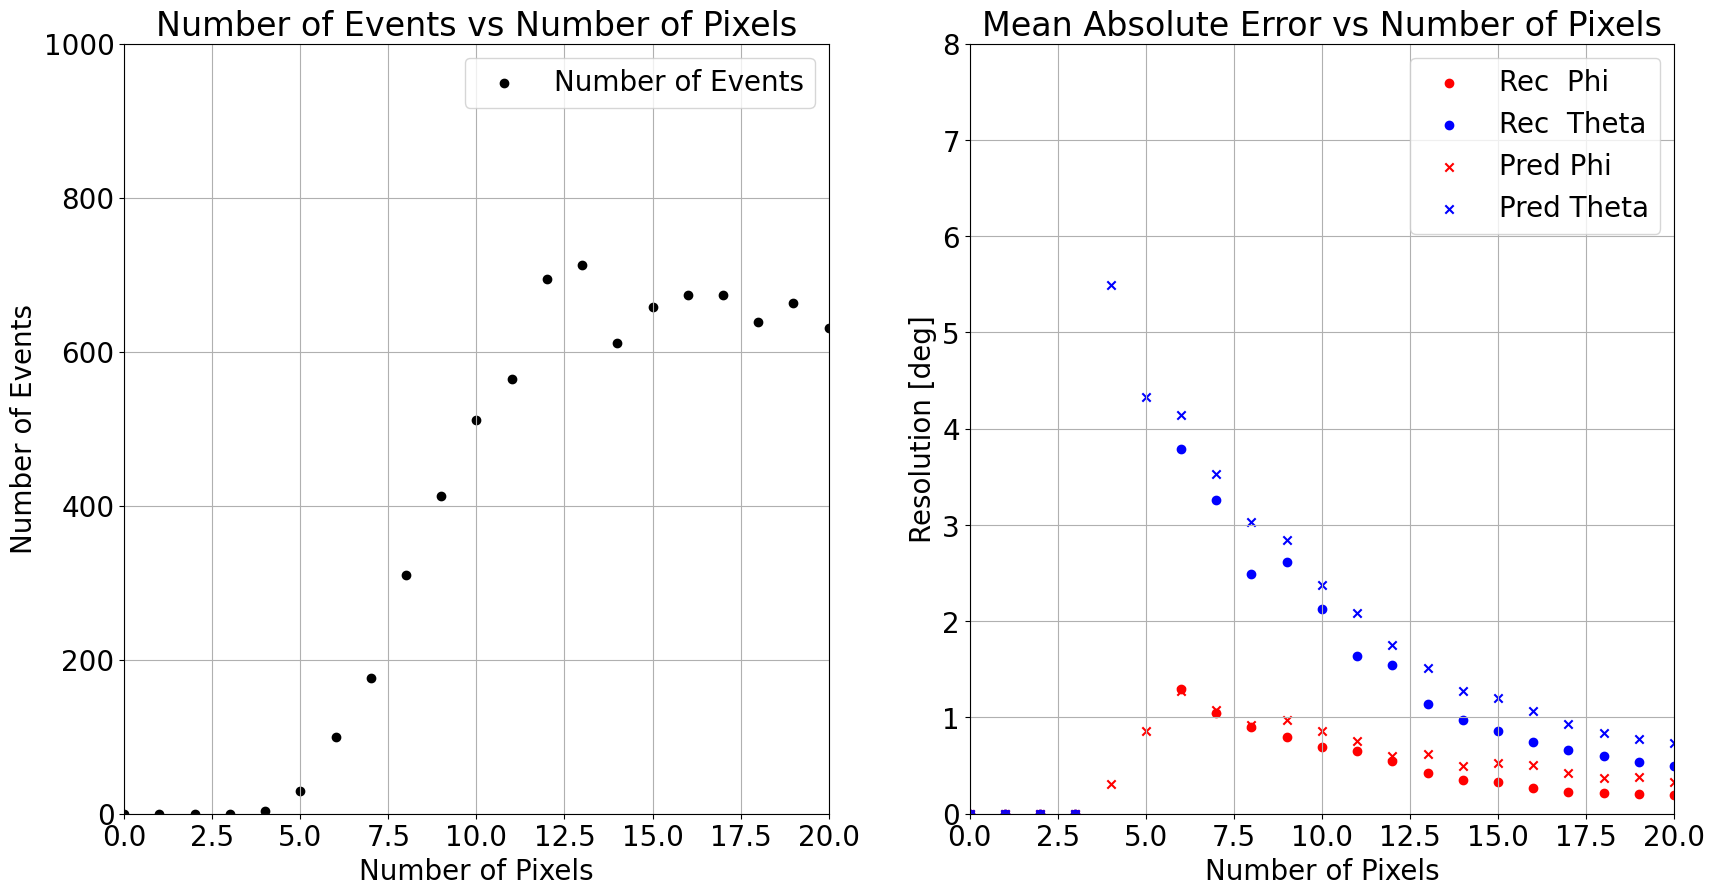

In [50]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
# 68% Percentile
# ax[0].scatter(range(N),PercentilesRec[:,0] ,label='Rec  Phi'  ,color='red')
# ax[0].scatter(range(N),PercentilesRec[:,1] ,label='Rec  Theta',color='blue')
# ax[0].scatter(range(N),PercentilesPred[:,0],label='Pred Phi'  ,color='red' ,marker='x')
# ax[0].scatter(range(N),PercentilesPred[:,1],label='Pred Theta',color='blue',marker='x')
# ax[0].set_xlabel('Number of Pixels')
# ax[0].set_ylabel('Resolution [deg]')
# ax[0].set_ylim(0,8)
# ax[0].set_xlim(0,20)
# ax[0].set_title('68% Resolution vs Number of Pixels')
# ax[0].legend()
# ax[0].grid()

# Pixel Number
ax[0].scatter(range(N),Nevents,label='Number of Events',color='black')
ax[0].set_xlabel('Number of Pixels')
ax[0].set_ylabel('Number of Events')
ax[0].set_ylim(0,1000)
ax[0].set_xlim(0,20)
ax[0].set_title('Number of Events vs Number of Pixels')
ax[0].legend()
ax[0].grid()

# 68% Percentile
# ax[1].scatter(range(N),PercentilesRec[:,0] ,label='Rec  Phi'  ,color='red')
# ax[1].scatter(range(N),PercentilesRec[:,1] ,label='Rec  Theta',color='blue')
# ax[1].scatter(range(N),PercentilesPred[:,0],label='Pred Phi'  ,color='red' ,marker='x')
# ax[1].scatter(range(N),PercentilesPred[:,1],label='Pred Theta',color='blue',marker='x')
# ax[1].set_xlabel('Number of Pixels')
# ax[1].set_ylabel('Resolution [deg]')
# ax[1].set_ylim(0,8)
# ax[1].set_xlim(0,20)
# ax[1].set_title('68% Resolution vs Number of Pixels')
# ax[1].legend()
# ax[1].grid()



# Mean Absolute Error
ax[1].scatter(range(N),MeanAbsErrRec[:,0] ,label='Rec  Phi'  ,color='red')
ax[1].scatter(range(N),MeanAbsErrRec[:,1] ,label='Rec  Theta',color='blue')
ax[1].scatter(range(N),MeanAbsErrPred[:,0],label='Pred Phi'  ,color='red' ,marker='x')
ax[1].scatter(range(N),MeanAbsErrPred[:,1],label='Pred Theta',color='blue',marker='x')
ax[1].set_xlabel('Number of Pixels')
ax[1].set_ylabel('Resolution [deg]')
ax[1].set_ylim(0,8)
ax[1].set_xlim(0,20)


In [ ]:
ax[1].set_title('Mean Absolute Error vs Number of Pixels')
ax[1].legend()
ax[1].grid()




In [48]:
torch.rot90(Main,k=1,dims=(2,3)).shape

torch.Size([17721, 2, 20, 22])